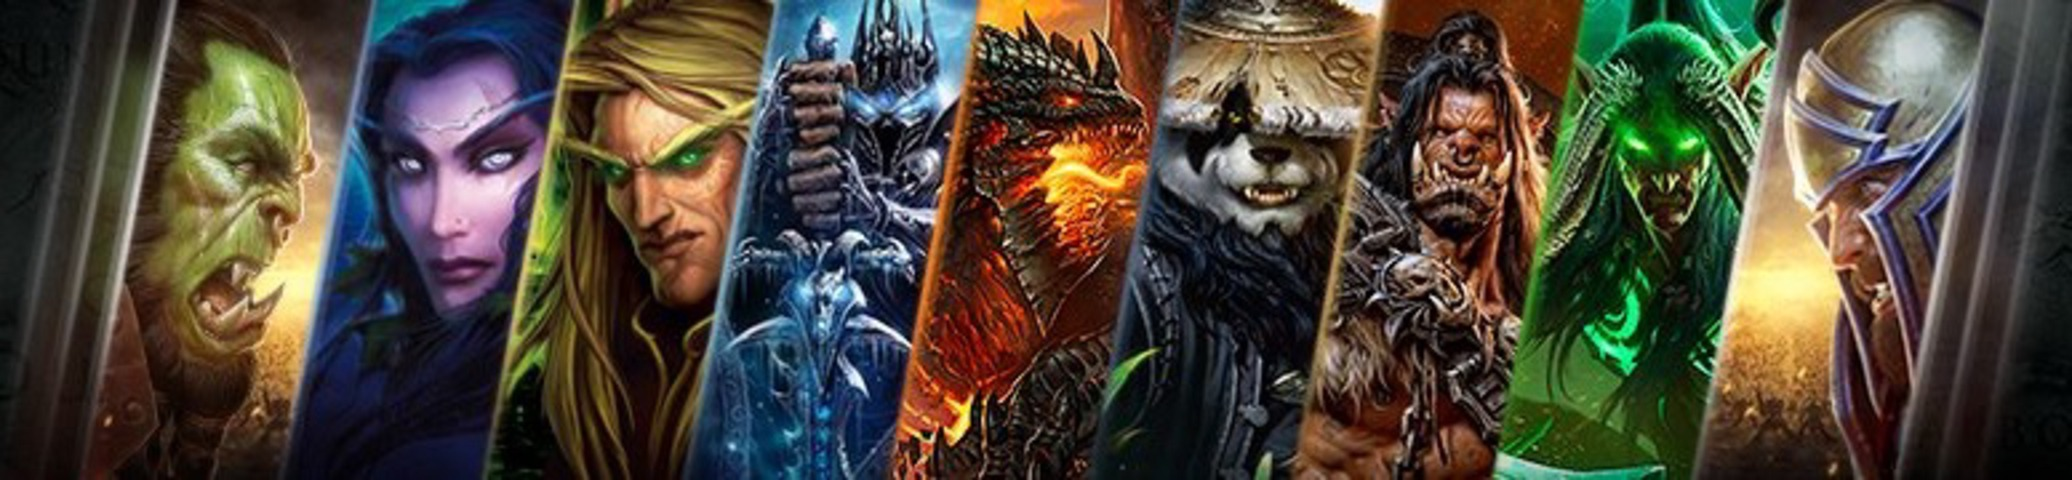

# <center>World of Warcraft Battleground Analysis</center>

---

## Problem Statement:

The dataset used for our analysis was obtained at https://www.kaggle.com/datasets/cblesa/world-of-warcraft-battlegrounds?select=wowsm.csv. This dataset contains player battleground statistics as well as information about each player's character. The following is the information on the dataset: <br>

In this dataset you will find five files with the statistics at the end of each battleground. Common statistics (columns) in all files are: <br>

* Code: code for the battleground (not needed for analysis).
* Faction: faction of the player (Horde or Alliance). 
* Class: class of the player (warrior, paladin, hunter, rogue, priest, death knight, shaman, mage, warlock, monk, druid, demon hunter).
* KB: number of mortal kills given by the player.
* D: number of times that the player died.
* HK: number of killings where the player or his/her group contributed.
* DD: damage done by the player.
* HD: healing done by the player.
* Honor: honor awarded to the player.
* Win: 1 if the player won.
* Lose: 1 if the player lost.
* Rol: dps if the player is a damage dealer; heal if the player is focused in healing allies. Note that not all classes can be healers, just shaman, paladin, priest, monk and druid, but all classes can be damage dealers.
* BE: some weeks there is a bonus event, when the honor gained is increased. 1 if the battleground happened during that week.

These columns, plus the "battleground" column are in wowbgs.csv file. Battleground column represent the kind of battleground:

* AB: Arathi basin.
* BG: Battle for Gilneas.
* DG: Deepwind gorge.
* ES: Eye of the storm.
* SA: Strand of the ancients.
* SM: Silvershard mines.
* SS: Seething shore.
* TK: Temple of Kotmogu.
* TP: Twin peaks.
* WG: Warsong gulch.

Note: This project will only be utilizing the main data file 'wowbgs2.csv' which contains information on all the battlegrounds. The other files found from the kaggle link can be used to analyze trends within specific battlegrounds, including analysis on features that are unique to a particular battleground.

---

In [1]:
#Basic Imports
import numpy as np, pandas as pd, matplotlib.pyplot as plt, seaborn as sns
%matplotlib inline

In [2]:
df = pd.read_csv('wowbgs2.csv')
df.head()

Battleground Code   Faction         Class  KB  D  HK     DD     HD  Honor  \
0           WG  WG1     Horde        Hunter   1  3  14  48155   6641    532   
1           WG  WG1     Horde  Death Knight   1  3  12  27025   7106    377   
2           WG  WG1  Alliance       Paladin   0  1  19    824  93879    252   
3           WG  WG1  Alliance       Paladin   1  2  25   7046  98599    274   
4           WG  WG1  Alliance         Rogue   2  3  23  65483  19629    268   

   Win  Lose   Rol  BE  
0  1.0   NaN   dps NaN  
1  1.0   NaN   dps NaN  
2  NaN   1.0  heal NaN  
3  NaN   1.0  heal NaN  
4  NaN   1.0   dps NaN

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5383 entries, 0 to 5382
Data columns (total 14 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Battleground  5383 non-null   object 
 1   Code          5383 non-null   object 
 2   Faction       5383 non-null   object 
 3   Class         5383 non-null   object 
 4   KB            5383 non-null   int64  
 5   D             5383 non-null   int64  
 6   HK            5383 non-null   int64  
 7   DD            5383 non-null   int64  
 8   HD            5383 non-null   int64  
 9   Honor         5383 non-null   int64  
 10  Win           2723 non-null   float64
 11  Lose          2660 non-null   float64
 12  Rol           5383 non-null   object 
 13  BE            954 non-null    float64
dtypes: float64(3), int64(6), object(5)
memory usage: 588.9+ KB


Looks like most of the columns don't have any missing values which is great! The 'Win' and 'Lose' column have NaN's where there should be zeros (these variables are binary and if you add the number of valid entries from both columns, it is equal to the total number of samples). We will correct this by dropping one of the columns and then filling the remaining column's NaNs with zeros. It also appears that there are missing values in the 'BE' column, but it has a similar issue as the win/lose columns where NaNs should be zeros (this will be an easy fix). Everything else looks great! Later in the predictive modeling section we will drop the 'Code' column since we can't use it. We will also prepare some dummy variables (one-hot encoding) for the categorical variables.

In [4]:
#Adjustments for NaN data points
df.drop('Lose',axis=1,inplace=True)
df['Win'].fillna(0,inplace=True)
df['BE'].fillna(0,inplace=True)

In [5]:
#Check that there is no more missing data
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5383 entries, 0 to 5382
Data columns (total 13 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Battleground  5383 non-null   object 
 1   Code          5383 non-null   object 
 2   Faction       5383 non-null   object 
 3   Class         5383 non-null   object 
 4   KB            5383 non-null   int64  
 5   D             5383 non-null   int64  
 6   HK            5383 non-null   int64  
 7   DD            5383 non-null   int64  
 8   HD            5383 non-null   int64  
 9   Honor         5383 non-null   int64  
 10  Win           5383 non-null   float64
 11  Rol           5383 non-null   object 
 12  BE            5383 non-null   float64
dtypes: float64(2), int64(6), object(5)
memory usage: 546.8+ KB


## Feature Engineering:

In [6]:
#Create column that lists which expansion the battleground is associated with
df['bg Expansion'] = ['Vanilla' if bg in ['WG','AB']
                                else 'WotLK' if bg in ['SA']
                                else 'Cataclysm' if bg in ['TP','BG']
                                else 'MoP' if bg in ['DG','SM','TK']
                                else 'Legion'
                                for bg in df['Battleground']]


#Create column that lists whether a particular class is pre-WotLK
df['Vanilla Class'] = [0 if clss in ['Death Knight','Demon Hunter','Monk']
                      else 1 for clss in df['Class']]


#Create column that says whether the player's character is melee, ranged, or capable of both
df['Class Type'] = ['Melee' if clss in ['Warrior','Demon Hunter','Death Knight','Rogue']
             else'Ranged' if clss in ['Mage','Warlock','Priest']
             else 'Both' for clss in df['Class']]


#Create column that shows armor proficiency of the player
df['Armor Type'] = ['Cloth' if clss in ['Mage','Warlock','Priest']
                   else 'Leather' if clss in ['Rogue','Druid','Monk','Demon Hunter']
                   else 'Mail' if clss in ['Hunter','Shaman']
                   else 'Plate' for clss in df['Class']]


#Create column that describes whether the player's class can summon a permanent pet (does not include temporary summons)
df['Pets'] = [1 if clss in ['Hunter','Warlock','Death Knight']
             else 0 for clss in df['Class']]



Feature Descriptions: <br>

* bg Expansion: Shows the expansion associated with the release of that battleground. 
<br>

* Vanilla Class: Distinguishes between characters that were available in the original game vs. characters that came out in later expansions. 1 is for classes that started in the original game and 0 is for classes that came out later. 
<br>

* Class Type: Classifies each class based on their effective range. If a class has multiple specs with different effective ranges, they will be labeled as 'both'. 
<br>

* Armor Type: Displays the armor proficiency of the character. 
<br>

* Pets: Distinguishes between characters that have the ability to use permanent pets or not (temporary summons are not considered as 'pets' here). 1 is for characters that can use permanent pets and 0 otherwise. 
<br>

In [7]:
#Check out the data with the new features included
df.sample(5)

Battleground  Code Faction    Class  KB  D  HK     DD     HD  Honor  Win  \
658            TK   TK1   Horde  Paladin   1  8  13  30888   4536    187  0.0   
2690           TK  TK20   Horde     Mage   5  3  39  86515  16473    254  0.0   
3908           SM  SM28   Horde    Druid   0  1  29  48240  29674    222  0.0   
2497           TP  TP16   Horde  Warlock   5  3  25  34091  17165    197  0.0   
257            WG  WG14   Horde  Warrior   7  5  26  33087   5365    178  0.0   

      Rol   BE bg Expansion  Vanilla Class Class Type Armor Type  Pets  
658   dps  0.0          MoP              1       Both      Plate     0  
2690  dps  0.0          MoP              1     Ranged      Cloth     0  
3908  dps  0.0          MoP              1       Both    Leather     0  
2497  dps  0.0    Cataclysm              1     Ranged      Cloth     1  
257   dps  0.0      Vanilla              1      Melee      Plate     0

---

## Exploratory Data Analysis

### General Insights:

In [8]:
#Drop binary categorical variables for the pairplot
mod_df = df.drop(['Win','BE','Vanilla Class','Pets'],axis=1)

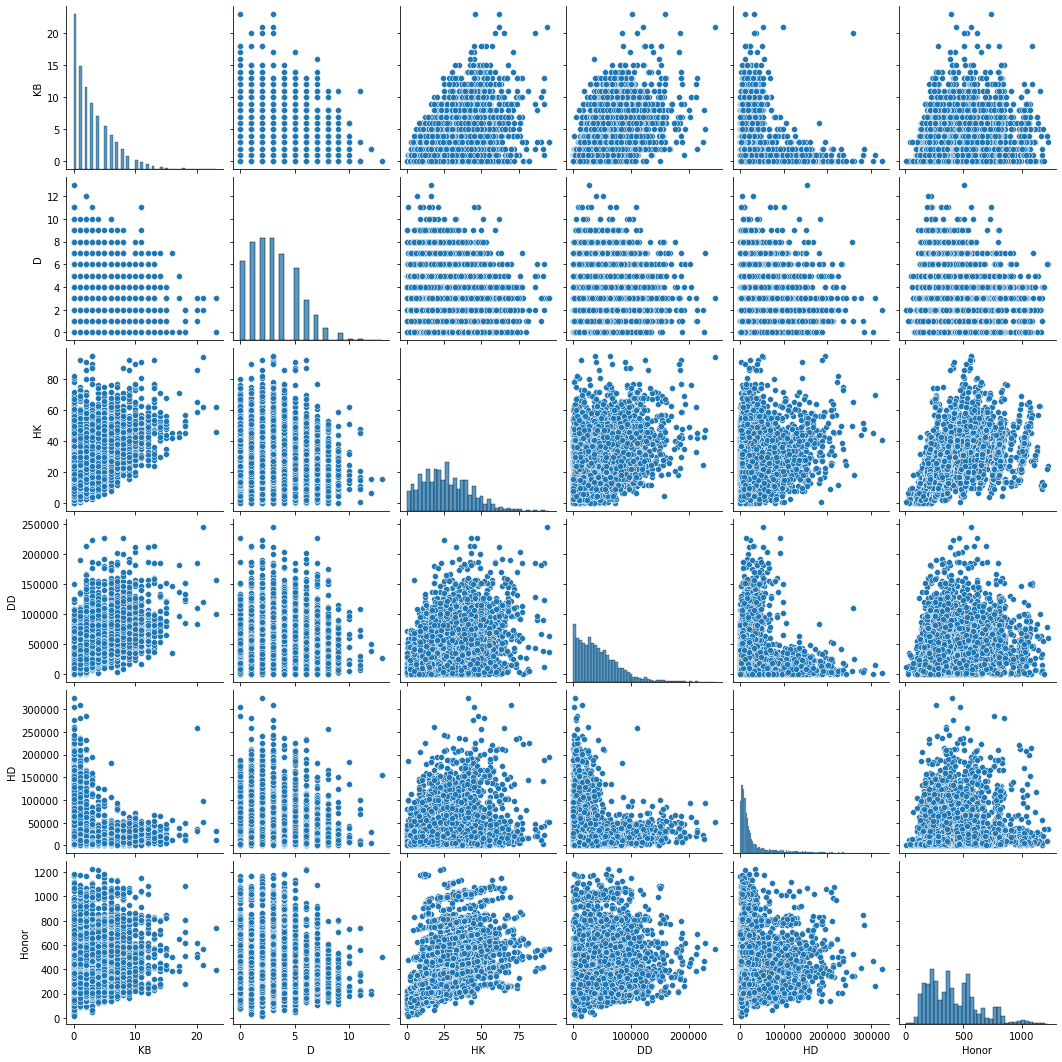

In [9]:
sns.pairplot(mod_df)

Points of interest: <br>

* HK vs. Honor: Although the cloud of points is pretty spread between these two variables, there is a slight linear correlation that we can see in the scatterplot. It makes sense that 'Honorable Kills' is positively correlated with 'Honor' since you get honor for those kills!
<br>

* HD vs. DD: This scatterplot shows that the relationship between these two variables is similar to an exponential decay. The more damage done the player has, the less healing done they typically have. This makes sense since the two roles perform well separately in each of these fields (healers will dominate HD and be horrible at DD).
<br>

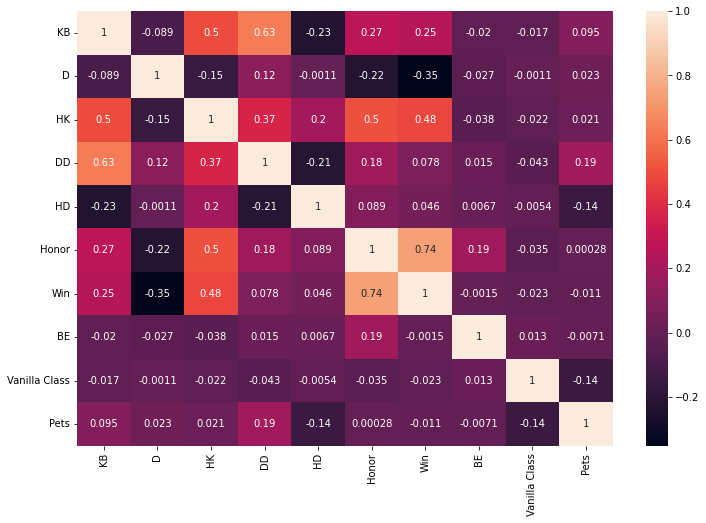

In [10]:
#Check correlation heat map for variables
sns.heatmap(data=df.corr(), annot=True)

fig=plt.gcf()
fig.set_size_inches(12,8)
plt.show()

After taking a closer look at the correlation heatmap, we can see that some items are heavily correlated and might need to be addressed before we do any predictive modeling: <br>

* Honor vs. Win: These two variables are highly correlated (0.74). This is the most worrysome correlation withing the data. If we try to solve a classification problem that attempts to make predicitons about a 'win', then honor will most likely be the most important feature for this task. Otherwise we might want to remove the 'honor' column before performing any other classifcation or regression tasks.
<br>

* Honorable Kills: HK's are correlated with Wins, Honor, and Killing Blows. It makes sense why HK's would be correlated with these items. We should be okay to use these features in any predicitve modeling since the correlation is <= 0.5. HK's are also slightly associated with the number of Deaths. This is most likely due to the fact that if a player is engage in more successful combat (more HK's), then they are most likely dying less.
<br>

* Damage Done vs. Killing Blows: These two variables have a slightly high correlation (0.63). If it was closer to 0.75 we would consider removing this variable prior to modeling, but we should be okay in this situation.
<br>

All the other variable relationships seem to be adequete for predictive modeling.

### Faction Insights:

In [11]:
faction_colors = {'Alliance':'royalblue','Horde':'firebrick'}

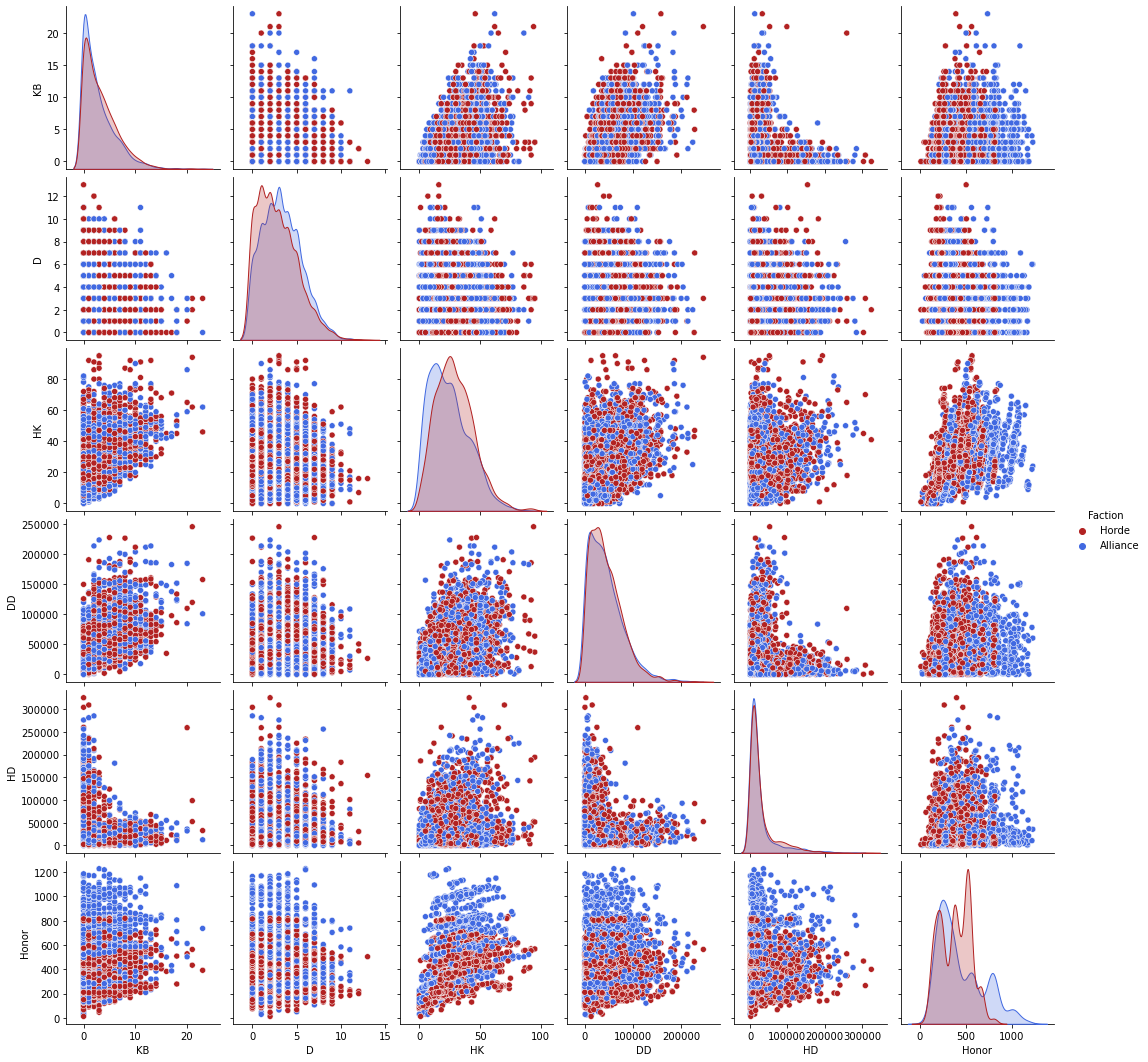

In [12]:
sns.pairplot(mod_df,hue='Faction',palette=faction_colors)

Quick Notes: <br>

We can see from the diagonal distributions that Alliance players tend to have more deaths on average while Horde players tend to have more Honorable Kills on average. <br>

The two factions are separated well in most of the scatterplots which is a good indidcation that our data will provide sufficient information for our models to distinguish between the two in a classification problem.

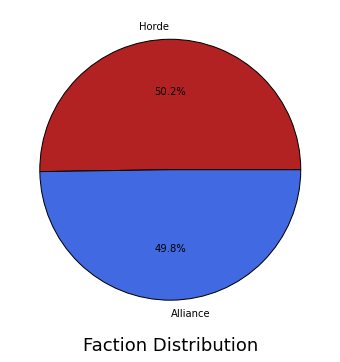

In [13]:
#Faction Distribution
wedge_settings = {"edgecolor":"k",'linewidth': 1, 'linestyle': 'solid'}
plt.pie(df['Faction'].value_counts(), autopct='%1.1f%%',colors = ['firebrick','royalblue'], wedgeprops=wedge_settings,
       labels=df['Faction'].unique())

fig=plt.gcf()
fig.set_size_inches(6,6)
plt.xlabel('Faction Distribution',size=18)
plt.show()

Looks like our dataset contains a fair balance of characters from both factions! This is desirable since we don't want class bias to influence our predictive modeling.

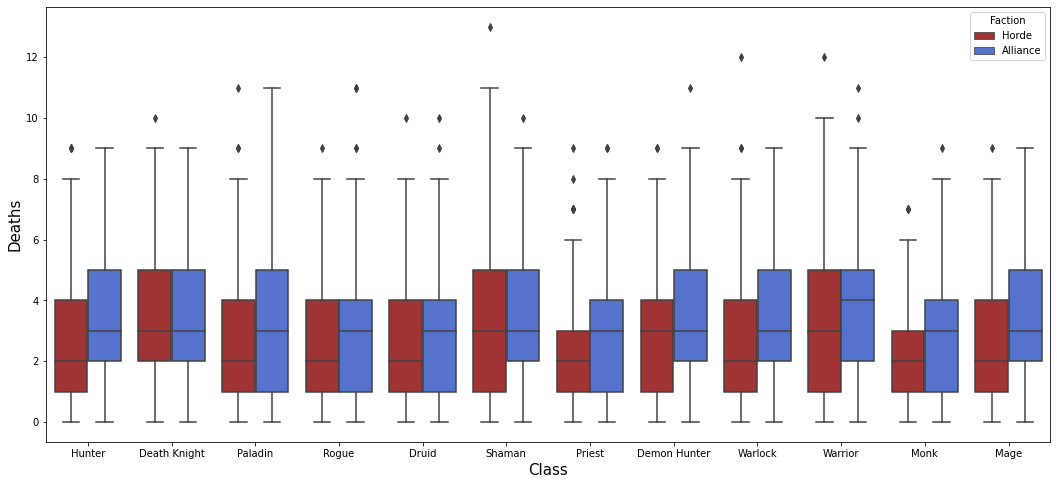

In [14]:
#Deaths per class separated by faction
faction_colors = {'Alliance':'royalblue','Horde':'firebrick'}
plot = sns.boxplot(x='Class', y='D', hue='Faction',data=df,palette=faction_colors)

plot.set_ylabel('Deaths', fontsize = 15)
plot.set_xlabel('Class',fontsize = 15)

fig=plt.gcf()
fig.set_size_inches(18,8)
plt.show()

These boxplots show that the Alliance characters in our dataset have more deaths than Horde characters. Some of the classes like Death Knight, Rogue, and Druid have similar death distributions. Other classes like Hunter, Demon Hunter, Monk, and Mage have a slight bias and it seems that amongst these classes, Alliance characters tend to die more. Although the disparity in deaths isn't too significant, this might suggest that the Horde perform a little better in battlegrounds. 

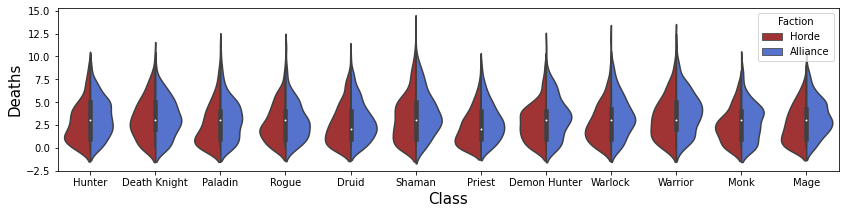

In [15]:
#Violonplot: Death distributions by class
palette = {'Alliance':'royalblue','Horde':'firebrick'}
plot = sns.violinplot(x='Class', y='D', hue='Faction',split=True,data=df,palette=palette)

plot.set_ylabel('Deaths', fontsize = 15)
plot.set_xlabel('Class',fontsize = 15)

fig=plt.gcf()
fig.set_size_inches(14,3)
plt.show()

This violin plot expands a little on the ideas we were exploring with the previous boxplots. It is clearer to see the distribution comparisons with this plot. As discussed previously we can see classes that tend to have a similar amount of deaths on average and classes where we can see Horde favored death statistics.

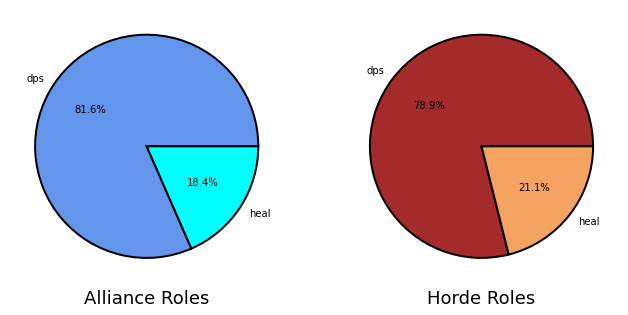

In [16]:
#Role distribution for each faction
alliance_roles = df[df['Faction'] == 'Alliance']['Rol'].value_counts()
horde_roles = df[df['Faction'] == 'Horde']['Rol'].value_counts()

wedge_settings = {"edgecolor":"k",'linewidth': 2, 'linestyle': 'solid'}

fig, axs = plt.subplots(1, 2, figsize=(11, 11))

axs[0].pie(alliance_roles, autopct='%1.1f%%',colors = ['cornflowerblue','aqua'], wedgeprops=wedge_settings,
       labels=df['Rol'].unique())
axs[1].pie(horde_roles, autopct='%1.1f%%',colors = ['brown','sandybrown'], wedgeprops=wedge_settings,
       labels=df['Rol'].unique())

axs[0].set_xlabel('Alliance Roles', size=18)
axs[1].set_xlabel('Horde Roles', size=18)

plt.show()

Looks like the two factions have a similar role distribution. The Horde seem to have a little more healers than the Alliance in this dataset, however the disparity isn't large enough to be worried about. The small difference in the amount of healers might explain why the Alliance have slightly more deaths in the dataset.

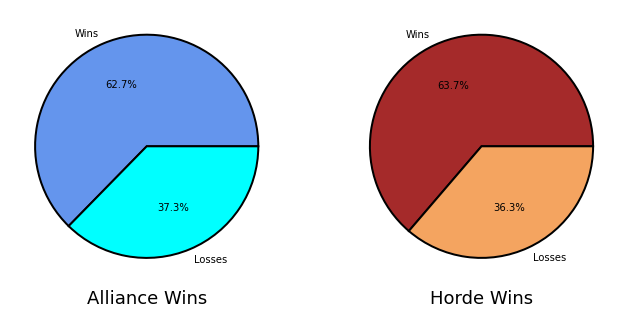

In [17]:
#Win distribution for each faction
alliance_wins = df[df['Faction'] == 'Alliance']['Win'].value_counts()
horde_wins = df[df['Faction'] == 'Horde']['Win'].value_counts()

wedge_settings = {"edgecolor":"k",'linewidth': 2, 'linestyle': 'solid'}

fig, axs = plt.subplots(1, 2, figsize=(11, 11))

axs[0].pie(alliance_wins, autopct='%1.1f%%',colors = ['cornflowerblue','aqua'], wedgeprops=wedge_settings,
       labels=['Wins','Losses'])
axs[1].pie(horde_wins, autopct='%1.1f%%',colors = ['brown','sandybrown'], wedgeprops=wedge_settings,
       labels=['Wins','Losses'])

axs[0].set_xlabel('Alliance Wins', size=18)
axs[1].set_xlabel('Horde Wins', size=18)

plt.show()

Overall, the two factions have similar win distributions. This is favorable because it indicates that the classes are balanced in the game when it comes to battlegrounds. One of the most important aspects of gameplay is managing balance, and our data suggests that one faction is not favored over the other when it comes to battleground PvP! (Don't blame your faction for losing!)

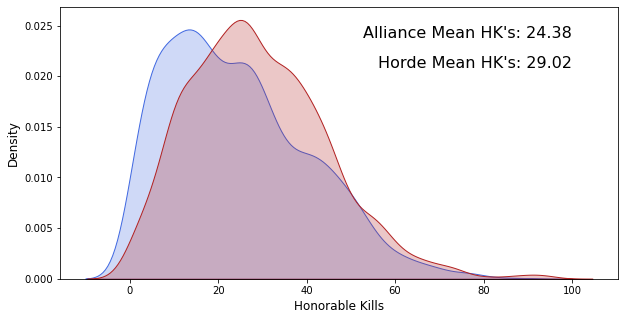

In [18]:
#Honorable kill distributions for each faction
alliance_hks = df[df['Faction'] == 'Alliance']['HK']
horde_hks = df[df['Faction'] == 'Horde']['HK']

alli_mean = round(alliance_hks.mean(),2)
horde_mean = round(horde_hks.mean(),2)

sns.kdeplot(alliance_hks,color='royalblue',fill=True)
sns.kdeplot(horde_hks,color='firebrick',fill=True)

fig=plt.gcf()
fig.set_size_inches(10,5)

plt.xlabel('Honorable Kills', size=12)
plt.ylabel('Density', size=12)

plt.annotate(f"Alliance Mean HK's: {alli_mean}", xy=(100,0.025), horizontalalignment='right', verticalalignment='top',size=16)
plt.annotate(f"Horde Mean HK's: {horde_mean}", xy=(100,0.022), horizontalalignment='right', verticalalignment='top',size=16)

plt.show()

We can see from this kernal density estimation plot that each faction's honorable kill distribution is slightly skewed to the right. In general, the Horde seem to have more honorable kills than the Alliance on average. Although this difference between the factions exist, we know from the previous plots that the distribution of wins is similar for both factions, so we can infer that having a high number of honorable kills does not necessarily guarantee victory. This pattern might indicate that the Horde have more of an inclination to fight and kill players, rather than playing directly for the objective (For the Horde!!). 

### Class Insights:

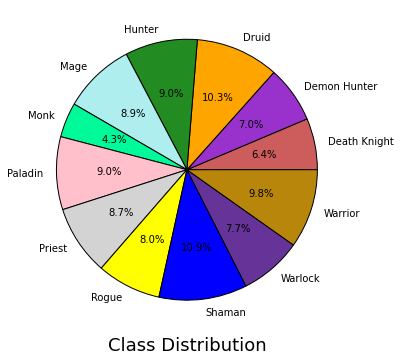

In [19]:
#Faction Distribution
class_labels = ['Death Knight','Demon Hunter','Druid','Hunter','Mage','Monk',
                'Paladin','Priest','Rogue','Shaman','Warlock','Warrior']
class_colors = {'Death Knight':'indianred',
               'Demon Hunter':'darkorchid',
               'Druid':'orange',
               'Hunter':'forestgreen',
               'Mage':'paleturquoise',
               'Monk':'mediumspringgreen',
               'Paladin':'pink',
               'Priest':'lightgrey',
               'Rogue':'yellow',
               'Shaman':'blue',
               'Warlock':'rebeccapurple',
               'Warrior':'darkgoldenrod'}

wedge_settings = {"edgecolor":"k",'linewidth': 1, 'linestyle': 'solid'}
df.groupby('Class').size().plot(kind='pie', autopct='%1.1f%%',ylabel='',colors=[class_colors[key] for key in class_labels]
                                ,wedgeprops=wedge_settings)

fig=plt.gcf()
fig.set_size_inches(6,6)
plt.xlabel('Class Distribution',size=18)
plt.show()

Looks like the classes are distributed pretty evenly within our dataset, with the exception of the monk class which is slightly underrepresented.

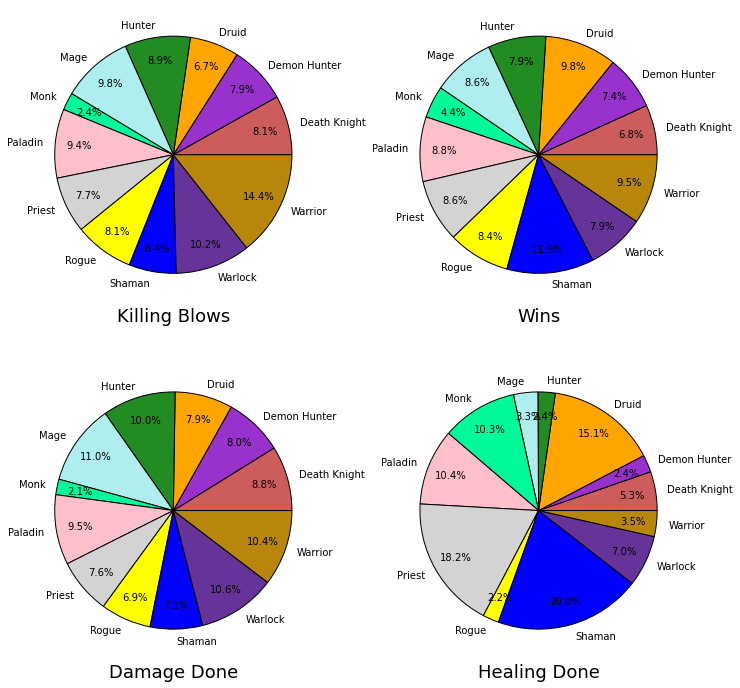

In [20]:
fig, axs = plt.subplots(2, 2, figsize=(12, 12))

df.groupby('Class')['KB'].sum().plot(kind='pie', autopct='%1.1f%%',ylabel='',colors=[class_colors[key] for key in class_labels],
                                      ax=axs[0, 0], wedgeprops=wedge_settings, pctdistance=0.8)
df.groupby('Class')['Win'].sum().plot(kind='pie', autopct='%1.1f%%',ylabel='',colors=[class_colors[key] for key in class_labels],
                                      ax=axs[0, 1],wedgeprops=wedge_settings, pctdistance=0.8)
df.groupby('Class')['DD'].sum().plot(kind='pie', autopct='%1.1f%%',ylabel='',colors=[class_colors[key] for key in class_labels],
                                     ax=axs[1, 0],wedgeprops=wedge_settings, pctdistance=0.8)
df.groupby('Class')['HD'].sum().plot(kind='pie', autopct='%1.1f%%',ylabel='',colors=[class_colors[key] for key in class_labels],
                                     ax=axs[1, 1],wedgeprops=wedge_settings, pctdistance=0.8)

axs[0, 0].set_xlabel('Killing Blows', size=18)
axs[0, 1].set_xlabel('Wins', size=18)
axs[1, 0].set_xlabel('Damage Done', size=18)
axs[1, 1].set_xlabel('Healing Done', size=18)

plt.show()

These pie charts give us a little bit more insight on some class trends. <br>

* Killing Blows: The best performer in this category is the warrior. This makes sense because warriors are always up in the action and most likely doing a lot of the "clean up" work in fights. They also carry a heavy potential to secure killing blows with their "execute" ability. We can see that the worst performer of the group is the monk. This may be because our dataset contains mostly monks who were healers (they would rarely get credit for a killing blow).
<br>

* Wins: Seems like the wins are pretty evenly distributed amongst the classes. The shaman shows some strength in this category. This could be completely biased based on our dataset, but it is something to keep in mind. If we analyze new battleground datasets and we see shaman as the class with the most wins, this might demonstrate the strength of the class and that having a shaman on the team will have a greater impact on obtaining a victory.
<br>

* Damage Done: Again we can see that the monk is underperforming in this category, most likely due to the fact that the monks in our dataset are mostly healers. The damage done by all the classes is pretty balanced, with the mage finding its way at the top (mages are glass cannons!).
<br>

* Healing Done: This category is a little more biased towards certain classes since not all classes have strong healing abilities. Here we can see the monk becoming more prevalent which confirms our assumption about their presence within the dataset as healers. Shaman and priest are absolutely crushing this category which means that they are dishing out tons of heals throughout the battleground. Perhaps the reason that shamans were at the top of the wins category was because of their large healing output. The druid class follows close behind with a decent chunk of the healing distribution.
<br>

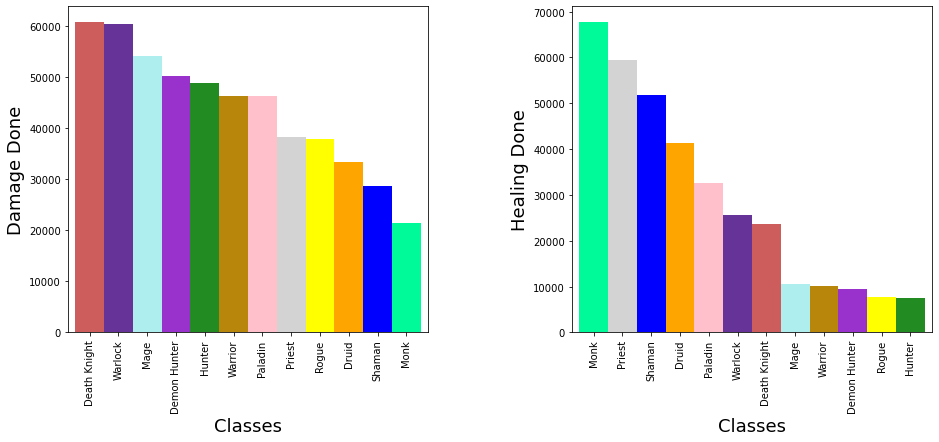

In [21]:
#Average Healing and Damage Done by class

index1 = df.groupby('Class')['DD'].mean().sort_values(ascending=False).index
index2 = df.groupby('Class')['HD'].mean().sort_values(ascending=False).index

fig, axs = plt.subplots(1, 2)

df.groupby('Class')['DD'].mean().sort_values(ascending=False).plot(kind='bar',color=[class_colors[key] for key in index1],
                                                                   width=1, ax=axs[0])

df.groupby('Class')['HD'].mean().sort_values(ascending=False).plot(kind='bar',color=[class_colors[key] for key in index2],
                                                                   width=1, ax=axs[1])


axs[0].set_xlabel('Classes',size=18)
axs[0].set_ylabel('Damage Done',size=18)

axs[1].set_xlabel('Classes',size=18)
axs[1].set_ylabel('Healing Done',size=18)

plt.subplots_adjust(wspace=0.4,
                   left=0.1,
                   right=1.3)

fig.set_size_inches(10,6)
plt.show()

These two charts compare the average healing done and damage done for each class. Comparing the averages can give us a better idea of the general class performance.

* Avg. Damage Done: The top three performers in this category are the death knight, warlock, and mage. These results are nice because the top damage dealers (on average) are mixed between melee and ranged classes (which indicates good balance). The under performers here were the druid, shaman, and monk. These three might be at the bottom of this category since our dataset contains healers from this class (they were spending time healing, not doing damage!). 
<br>

* Avg. Healing Done: The top three performers in this category are the monk, priest, and shaman. It is interesting to see that on average the monk is outperforming the priest and shaman on heals, but this might be coming from our bias in the dataset (more monk healers than monk dps). It is also interesting that the warlock and deathknight show some signs of good healing performance. Of course these come from self-healing abilities (they are not healing allies).
<br>

### Role Insights:

In [22]:
role_colors = ['indianred','mediumspringgreen']

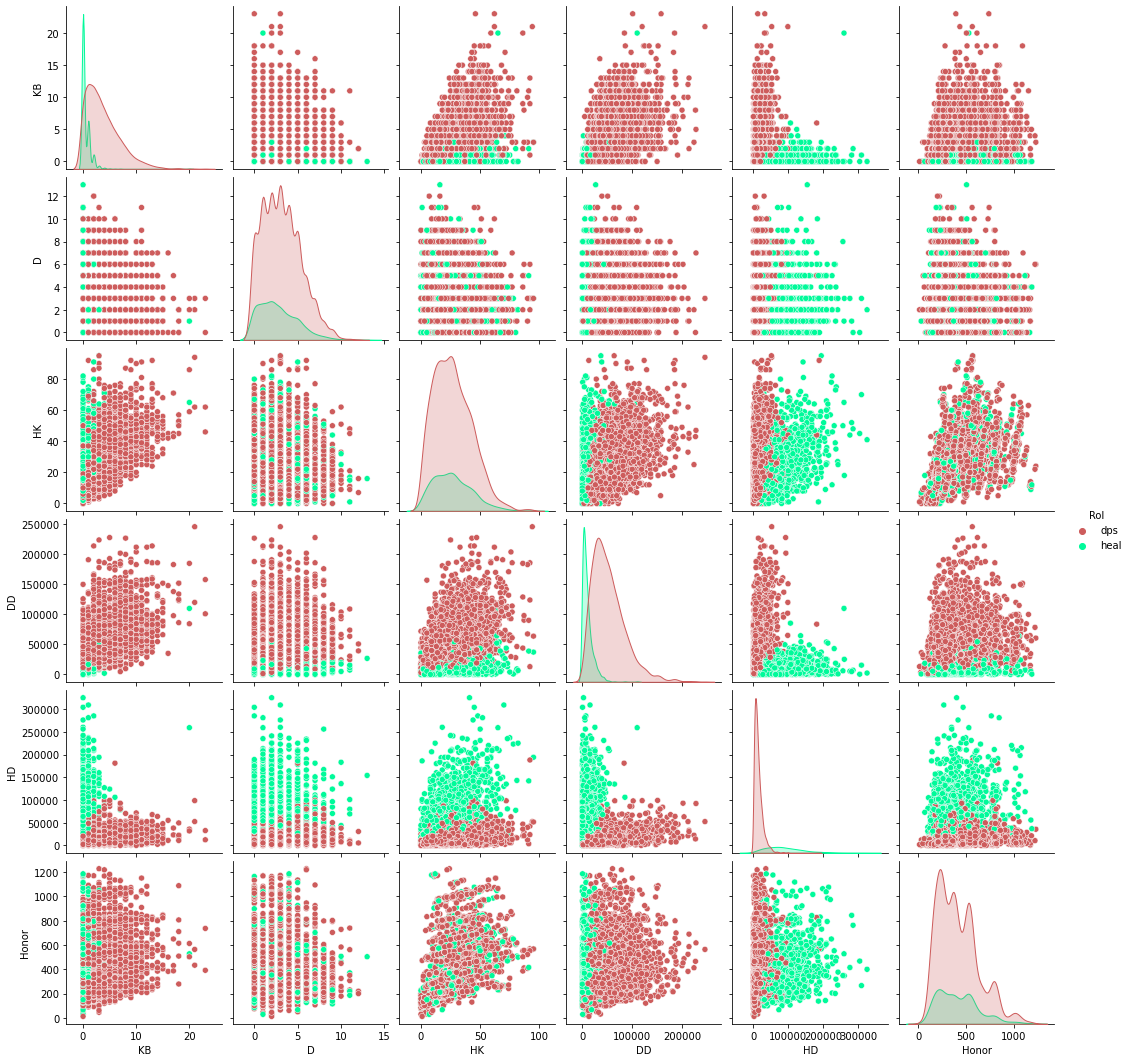

In [23]:
sns.pairplot(mod_df,hue='Rol',palette=role_colors)

Quick Notes: <br>

Most of the scatterplots show a good separation of roles here which is a good indication that our data would be able to classify the two roles well. Some variables like honorable kills and honor are not well separated and our predicitve models may not get much information from them. 

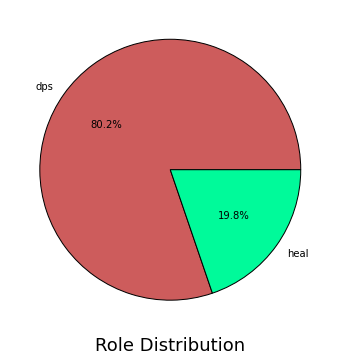

In [24]:
#Role Distribution
wedge_settings = {"edgecolor":"k",'linewidth': 1, 'linestyle': 'solid'}
plt.pie(df['Rol'].value_counts(), autopct='%1.1f%%',colors = role_colors, wedgeprops=wedge_settings,
       labels=df['Rol'].unique())

fig=plt.gcf()
fig.set_size_inches(6,6)
plt.xlabel('Role Distribution',size=18)
plt.show()

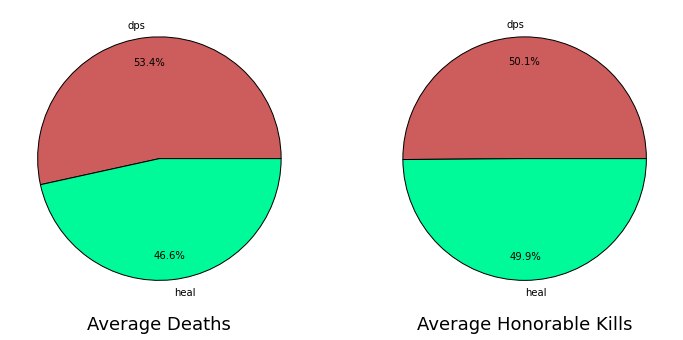

In [25]:
#Average Deaths and Average Honorable Kills by role
fig, axs = plt.subplots(1, 2, figsize=(12, 12))

df.groupby('Rol').mean()['D'].plot(kind='pie', autopct='%1.1f%%',ylabel='',colors=role_colors,
                                      ax=axs[0], wedgeprops=wedge_settings, pctdistance=0.8)
df.groupby('Rol').mean()['HK'].plot(kind='pie', autopct='%1.1f%%',ylabel='',colors=role_colors,
                                      ax=axs[1],wedgeprops=wedge_settings, pctdistance=0.8)


axs[0].set_xlabel('Average Deaths', size=18)
axs[1].set_xlabel('Average Honorable Kills', size=18)


plt.show()

With these pie charts, we can see how role is associated with some of the battleground statistics. Healing done and damage done have purposely been excluded since dps will most likely dominate damage done and healers will dominate healing done.

* Avg. Deaths: Seems like dps players die a little more often on average than healers in battlegrounds. This makes sense since healers can usually do a good job of keeping themselves alive with their healing spells. Sometimes dps players are caught in fights with no friendly healers and this will increase their chances of dying.
<br>

* Average Honorable Kills: It's a good sign that the average honorable kills is distributed evenly amongst the roles. Honorable Kills are a good measure of combat participation (not necesarrily just killing), so it's good to see that each role gets their fair share of combat.
<br>

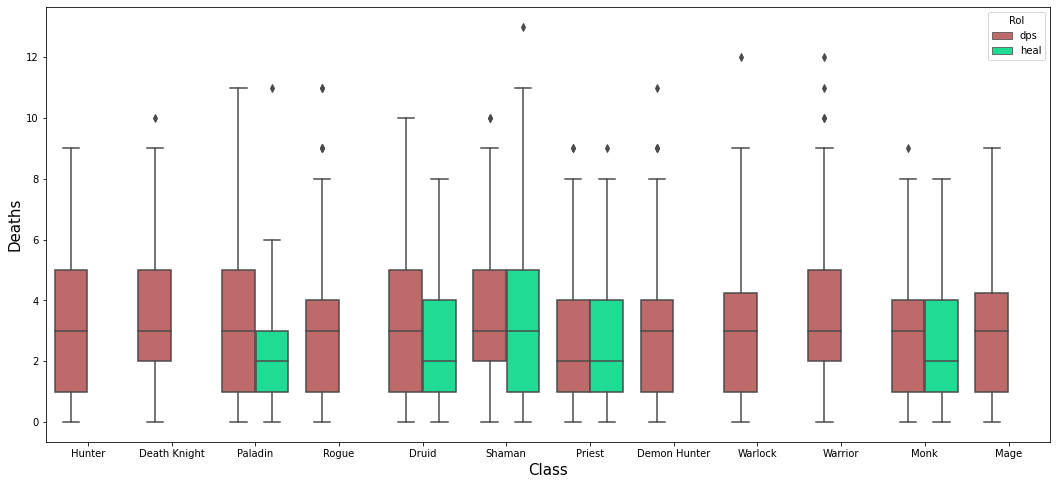

In [27]:
#Deaths per class separated by role
plot = sns.boxplot(x='Class', y='D', hue='Rol',data=df,palette=role_colors)

plot.set_ylabel('Deaths', fontsize = 15)
plot.set_xlabel('Class',fontsize = 15)

fig=plt.gcf()
fig.set_size_inches(18,8)
plt.show()

From these boxplots we can see that the number of deaths for dps is pretty evenly distributed over the different classes. We do notice a difference in the healers though; it seems that paladin and druid healers are more survivable than the other healers who tend to die just about as often as their dps counterparts.

### Other Insights:

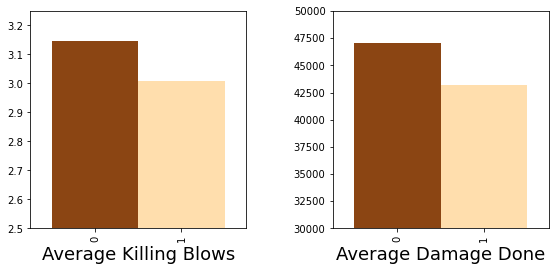

In [28]:
#Average killing blows and deaths for vanilla and non-vanilla classes.
fig, axs = plt.subplots(1, 2)

df.groupby('Vanilla Class')['KB'].mean().sort_values(ascending=False).plot(kind='bar',color=['saddlebrown','navajowhite'],
                                                                   width=1, ax=axs[0])

df.groupby('Vanilla Class')['DD'].mean().sort_values(ascending=False).plot(kind='bar',color=['saddlebrown','navajowhite'],
                                                                   width=1, ax=axs[1])


axs[0].set_ylim(2.5,3.25)
axs[1].set_ylim(30000,50000)

axs[0].set_xlabel('Average Killing Blows', size=18)
axs[1].set_xlabel('Average Damage Done', size=18)


plt.subplots_adjust(wspace=0.4,
                   left=0.1,
                   right=1.3)

plt.show()

With the addition of new classes to WoW, it is important to make sure that they are balanced compared to the other pre-existing classes. These plots compare some statistics based on whether the class was in 'vanilla' WoW or if it was a new class added to the game. <br>

* Average Killing Blows: On average, the non-vanilla classes are getting more killing blows in battlegrounds. This could be because of certain abilities that do high burst damage, or it could be an indication that the non-vanilla classes are a bit stronger overall in combat. 
<br>

* Average Damage Done: We also have that non-vanilla classes are doing more damage overall. This is something that might need to be investigated further if balance is the issue at hand. The disparity between the amount of damage done isn't too large, but it something that we should still keep in mind.
<br>

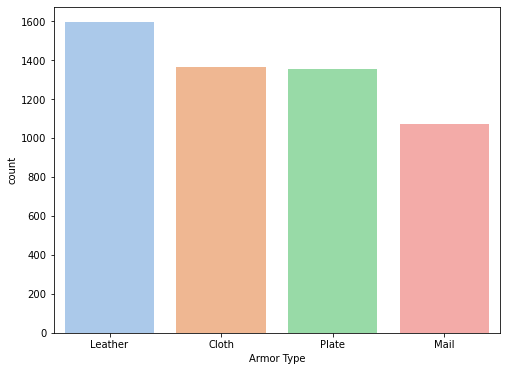

In [29]:
#Counts for each armor type
sns.countplot(x='Armor Type',data=df,order=df['Armor Type'].value_counts().index,palette='pastel')

fig=plt.gcf()
fig.set_size_inches(8,6)
plt.show()

Looks like most of our data is made up of leather and cloth wearing classes!

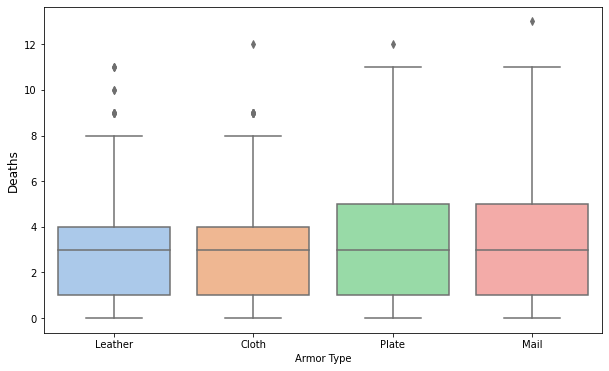

In [30]:
sns.boxplot(x='Armor Type',y='D',data=df,order=df['Armor Type'].value_counts().index,palette='pastel')

fig=plt.gcf()
plt.ylabel('Deaths',size=12)
fig.set_size_inches(10,6)
plt.show()

These boxplots give us a good idea of how deaths are distributed amonst the different armor types. The average deaths is about the same between all the armor types, but the plate and mail death distributions stretch a bit farther (there were more cases of plate/mail wearers having a higher number of deaths).

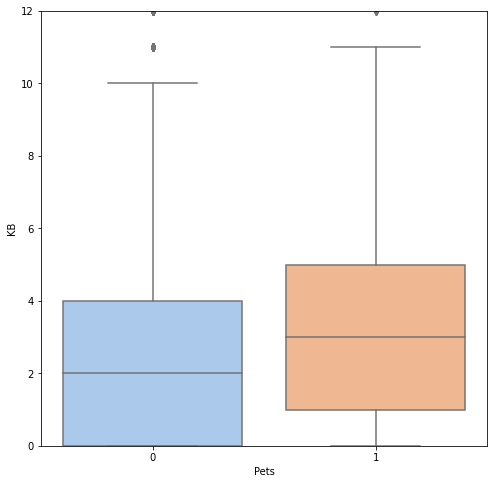

In [31]:
#Killing blows separated by classes that can use permanent pets
sns.boxplot(x='Pets',y='KB',data=df,palette='pastel')

fig=plt.gcf()
fig.set_size_inches(8,8)

plt.ylim(0,12)
plt.show()

This plot shows that on average, the classes that can use permanent pets generally have more killing blows than classes that cannot. The 'non-pet' distribution might be slightly influenced by the fact that there are no healing classes that can use pets (healers don't get a lot of killing blows), so the healers might be bringing the distribution down a little.

---

# Predictive Modeling

In [32]:
#Setting up the data for modeling
df.drop(['Code'],axis=1,inplace=True) #Drop Honor because of high correlation

#Convert to binary
df['Faction'] = [1 if faction == 'Horde' else 0 for faction in df['Faction']]
df['Rol'] = [1 if role == 'dps' else 0 for role in df['Rol']]

#Get dummies for categorical variables
BG = pd.get_dummies(df['Battleground'],prefix='BG')
Classes = pd.get_dummies(df['Class'])
ClassType= pd.get_dummies(df['Class Type'],prefix='Ctype')
Armor = pd.get_dummies(df['Armor Type'])
Expansion = pd.get_dummies(df['bg Expansion'])

#Drop the variables we created dummies for
df.drop(['Battleground','Class','Class Type','Armor Type','bg Expansion'],axis=1,inplace=True)
df = pd.concat([df,BG,Classes,ClassType,Armor,Expansion],axis=1)

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5383 entries, 0 to 5382
Data columns (total 46 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Faction        5383 non-null   int64  
 1   KB             5383 non-null   int64  
 2   D              5383 non-null   int64  
 3   HK             5383 non-null   int64  
 4   DD             5383 non-null   int64  
 5   HD             5383 non-null   int64  
 6   Honor          5383 non-null   int64  
 7   Win            5383 non-null   float64
 8   Rol            5383 non-null   int64  
 9   BE             5383 non-null   float64
 10  Vanilla Class  5383 non-null   int64  
 11  Pets           5383 non-null   int64  
 12  BG_AB          5383 non-null   uint8  
 13  BG_BG          5383 non-null   uint8  
 14  BG_DG          5383 non-null   uint8  
 15  BG_ES          5383 non-null   uint8  
 16  BG_SA          5383 non-null   uint8  
 17  BG_SM          5383 non-null   uint8  
 18  BG_SS   

In [33]:
#Modeling imports
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, roc_curve

## Classification: Predicting Faction

In this section we will consider a classification problem where we try to predict a player's faction based on the other variables in the dataset. Different models will be proposed and then a final model will be suggested for use on future data.

In [34]:
#Prepping the data
X = np.array(df.drop('Faction',axis=1))
Y = np.array(df['Faction'])

XTRAIN, XTEST, YTRAIN, YTEST = train_test_split(X,Y,shuffle=True,random_state=69)

### Logistic Regression Model

In [35]:
from sklearn.linear_model import LogisticRegression as LR

In [36]:
lr = LR()
lr.fit(XTRAIN,YTRAIN)
predictions = lr.predict(XTEST)

print(classification_report(YTEST,predictions))

              precision    recall  f1-score   support

           0       0.62      0.68      0.65       681
           1       0.64      0.58      0.61       665

    accuracy                           0.63      1346
   macro avg       0.63      0.63      0.63      1346
weighted avg       0.63      0.63      0.63      1346



Our first attempt with logistic regression didn't come out too great. Let's see if we can manipulate the data to achieve better results!

In [37]:
#Min Max Scaler Model
scaler = MinMaxScaler()
scaler.fit(XTRAIN)
XTRAIN = scaler.transform(XTRAIN)
XTEST = scaler.transform(XTEST)

lr = LR()
lr.fit(XTRAIN,YTRAIN)
predictions = lr.predict(XTEST)

print(classification_report(YTEST,predictions))

              precision    recall  f1-score   support

           0       0.80      0.84      0.82       681
           1       0.83      0.78      0.81       665

    accuracy                           0.81      1346
   macro avg       0.81      0.81      0.81      1346
weighted avg       0.81      0.81      0.81      1346



In [38]:
print(confusion_matrix(YTEST,predictions))

[[573 108]
 [143 522]]


Implementing the MinMax scaler helped a lot! We were able to increase the accuracy by almost 20%. We can see from the confusion matrix that our model is still making a ton of errors when predicting.

In [39]:
#Standard Scaler Model
XTRAIN, XTEST, YTRAIN, YTEST = train_test_split(X,Y,shuffle=True,random_state=69)

scaler = StandardScaler()
scaler.fit(XTRAIN)
XTRAIN = scaler.transform(XTRAIN)
XTEST = scaler.transform(XTEST)

lr = LR()
lr.fit(XTRAIN,YTRAIN)
predictions = lr.predict(XTEST)

print(classification_report(YTEST,predictions))

              precision    recall  f1-score   support

           0       0.83      0.86      0.85       681
           1       0.85      0.82      0.84       665

    accuracy                           0.84      1346
   macro avg       0.84      0.84      0.84      1346
weighted avg       0.84      0.84      0.84      1346



In [40]:
print(confusion_matrix(YTEST,predictions))

[[588  93]
 [117 548]]


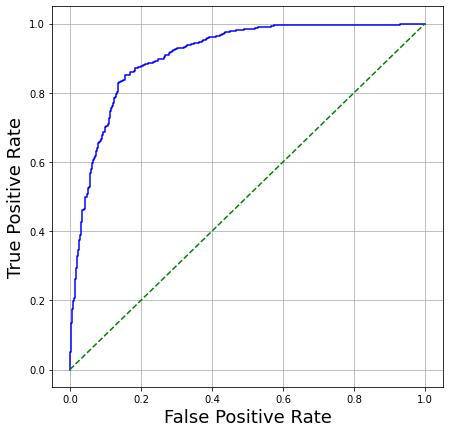

In [41]:
probs=lr.predict_proba(XTEST)[:,1]
fpr, tpr, threshold = roc_curve(YTEST,probs)
plt.plot(fpr,tpr, c="blue")
plt.plot([0,1],[0,1],c="green",ls="--")
plt.xlabel("False Positive Rate", fontsize=18)
plt.ylabel("True Positive Rate", fontsize=18)
plt.grid()
plt.gcf().set_size_inches(7,7)

As we can see from the ROC curve, our model is performing okay, but not as well as we'd like it to. We are looking for a model that pulls the bow of the curve closer to the top left corner of the plot.

### Discriminant Analysis Models

In [42]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis

LDA=LinearDiscriminantAnalysis()
QDA=QuadraticDiscriminantAnalysis()

In [43]:
#Linear Discriminant Analysis
XTRAIN, XTEST, YTRAIN, YTEST = train_test_split(X,Y,shuffle=True,random_state=69)

LDA.fit(XTRAIN,YTRAIN)
predictions = LDA.predict(XTEST)

print(classification_report(YTEST,predictions))

              precision    recall  f1-score   support

           0       0.78      0.84      0.81       681
           1       0.82      0.75      0.79       665

    accuracy                           0.80      1346
   macro avg       0.80      0.80      0.80      1346
weighted avg       0.80      0.80      0.80      1346



In [44]:
print(confusion_matrix(YTEST,predictions))

[[574 107]
 [163 502]]


In [45]:
#Min Max Scaler
scaler = MinMaxScaler()
scaler.fit(XTRAIN)
XTRAIN = scaler.transform(XTRAIN)
XTEST = scaler.transform(XTEST)

LDA.fit(XTRAIN,YTRAIN)
predictions = LDA.predict(XTEST)

print(classification_report(YTEST,predictions))

              precision    recall  f1-score   support

           0       0.78      0.84      0.81       681
           1       0.82      0.75      0.79       665

    accuracy                           0.80      1346
   macro avg       0.80      0.80      0.80      1346
weighted avg       0.80      0.80      0.80      1346



In this case scaling the data did not help to improve our model accuracy.

In [46]:
#Quadratic Discriminant Analysis
XTRAIN, XTEST, YTRAIN, YTEST = train_test_split(X,Y,shuffle=True,random_state=69)

QDA.fit(XTRAIN,YTRAIN)
predictions = QDA.predict(XTEST)

print(classification_report(YTEST,predictions))

              precision    recall  f1-score   support

           0       0.82      0.66      0.73       681
           1       0.71      0.86      0.78       665

    accuracy                           0.75      1346
   macro avg       0.77      0.76      0.75      1346
weighted avg       0.77      0.75      0.75      1346



C:\Users\leave\anaconda3\lib\site-packages\sklearn\discriminant_analysis.py:808: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


In [47]:
#Min Max Scaler
scaler = MinMaxScaler()
scaler.fit(XTRAIN)
XTRAIN = scaler.transform(XTRAIN)
XTEST = scaler.transform(XTEST)

QDA.fit(XTRAIN,YTRAIN)
predictions = QDA.predict(XTEST)

print(classification_report(YTEST,predictions))

              precision    recall  f1-score   support

           0       0.62      0.53      0.57       681
           1       0.58      0.67      0.62       665

    accuracy                           0.60      1346
   macro avg       0.60      0.60      0.59      1346
weighted avg       0.60      0.60      0.59      1346



C:\Users\leave\anaconda3\lib\site-packages\sklearn\discriminant_analysis.py:808: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


In this case scaling the data actually made the quadratic model worse.

In [48]:
#PCA Analysis Import
from sklearn.decomposition import PCA

In [49]:
#With Principle Component Analysis (LDA)
XTRAIN, XTEST, YTRAIN, YTEST = train_test_split(X,Y,shuffle=True,random_state=69)

pca = PCA(n_components=2)
pca.fit(XTRAIN)

XTRAIN = pca.transform(XTRAIN)
XTEST = pca.transform(XTEST)

LDA.fit(XTRAIN,YTRAIN)
predictions = LDA.predict(XTEST)

print(classification_report(YTEST,predictions))

              precision    recall  f1-score   support

           0       0.52      0.57      0.54       681
           1       0.51      0.46      0.48       665

    accuracy                           0.51      1346
   macro avg       0.51      0.51      0.51      1346
weighted avg       0.51      0.51      0.51      1346



In [50]:
#With Principle Component Analysis (QDA)
XTRAIN, XTEST, YTRAIN, YTEST = train_test_split(X,Y,shuffle=True,random_state=69)

pca = PCA(n_components=2)
pca.fit(XTRAIN)

XTRAIN = pca.transform(XTRAIN)
XTEST = pca.transform(XTEST)

QDA.fit(XTRAIN,YTRAIN)
predictions = QDA.predict(XTEST)

print(classification_report(YTEST,predictions))

              precision    recall  f1-score   support

           0       0.53      0.44      0.48       681
           1       0.51      0.59      0.55       665

    accuracy                           0.52      1346
   macro avg       0.52      0.52      0.51      1346
weighted avg       0.52      0.52      0.51      1346



Using principle component analysis in this case made our models much worse. We will not use PCA with either of these models.

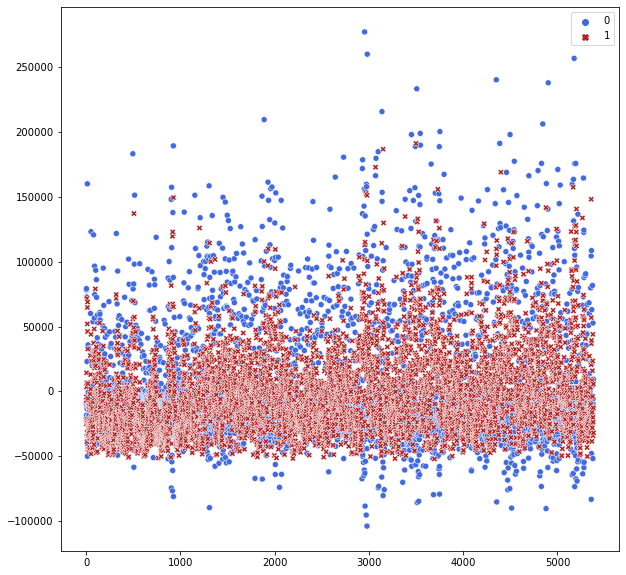

In [51]:
#ADD XLABELS AND Y LABELS
pca = PCA(n_components=2)
pca.fit(X)

TX = pca.transform(X)

plot = sns.scatterplot(data=TX,palette=['royalblue','firebrick'])

fig=plt.gcf()
fig.set_size_inches(10,10)
plt.show()

Plotting our top two principle components gives us a good idea of why our discriminant analysis isn't working well. For the linear and quadratic case, it is very difficult to draw a straight line (or quadratic curve) to separate the data points well.

### Tree Ensembles

In [52]:
from sklearn.tree import DecisionTreeClassifier as DT
from sklearn.ensemble import BaggingClassifier as BAG
from sklearn.ensemble import GradientBoostingClassifier as GBC
from sklearn.ensemble import RandomForestClassifier as RF

In [53]:
#Basic Decision Tree
XTRAIN, XTEST, YTRAIN, YTEST = train_test_split(X,Y,shuffle=True,random_state=69)

model = DT(max_depth=None)
model.fit(XTRAIN,YTRAIN)
predictions = model.predict(XTEST)
print(classification_report(YTEST,predictions))

              precision    recall  f1-score   support

           0       0.87      0.89      0.88       681
           1       0.89      0.86      0.88       665

    accuracy                           0.88      1346
   macro avg       0.88      0.88      0.88      1346
weighted avg       0.88      0.88      0.88      1346



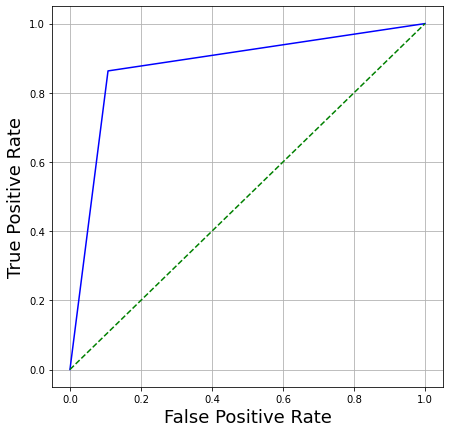

In [54]:
probs=model.predict_proba(XTEST)[:,1]
fpr, tpr, threshold = roc_curve(YTEST,probs)
plt.plot(fpr,tpr, c="blue")
plt.plot([0,1],[0,1],c="green",ls="--")
plt.xlabel("False Positive Rate", fontsize=18)
plt.ylabel("True Positive Rate", fontsize=18)
plt.grid()
plt.gcf().set_size_inches(7,7)

Looks like a basic decision tree performs fairly well for our classification problem. Since a regular decision tree is performing good, we will most likely not gain much from the ensemble methods (random forest, bagging, boosting), but let's see if we can squeeze out any extra model performance.

In [55]:
bagmodel = BAG(n_estimators=5)
bagmodel.fit(XTRAIN,YTRAIN)
bagpredictions = bagmodel.predict(XTEST)
print(classification_report(YTEST,bagpredictions))

              precision    recall  f1-score   support

           0       0.89      0.89      0.89       681
           1       0.89      0.89      0.89       665

    accuracy                           0.89      1346
   macro avg       0.89      0.89      0.89      1346
weighted avg       0.89      0.89      0.89      1346



In [56]:
boostmodel = GBC(n_estimators=100)
boostmodel.fit(XTRAIN,YTRAIN)
boostpredictions = boostmodel.predict(XTEST)
print(classification_report(YTEST,boostpredictions))

              precision    recall  f1-score   support

           0       0.89      0.88      0.88       681
           1       0.88      0.89      0.88       665

    accuracy                           0.88      1346
   macro avg       0.88      0.88      0.88      1346
weighted avg       0.88      0.88      0.88      1346



In [57]:
rfmodel = RF(n_estimators=100)
rfmodel.fit(XTRAIN,YTRAIN)
rfpredictions = rfmodel.predict(XTEST)
print(classification_report(YTEST,rfpredictions))

              precision    recall  f1-score   support

           0       0.87      0.85      0.86       681
           1       0.85      0.87      0.86       665

    accuracy                           0.86      1346
   macro avg       0.86      0.86      0.86      1346
weighted avg       0.86      0.86      0.86      1346



In [58]:
tree_info = {'Decision Tree': {'Accuracy':0.88},
            'Random Forest': {'Accuracy':0.85},
            'Gradient Boost': {'Accuracy':0.90},
            'Bagging': {'Accuracy':0.88}}

#Comparison of tree models
tree_df = pd.DataFrame(tree_info).transpose()
tree_df.head()

Accuracy
Decision Tree       0.88
Random Forest       0.85
Gradient Boost      0.90
Bagging             0.88

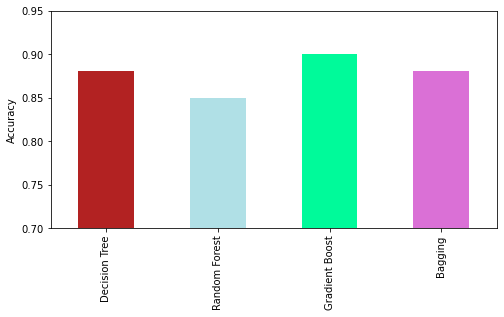

In [59]:
tree_df['Accuracy'].plot(kind='bar',color=['firebrick','powderblue','mediumspringgreen','orchid'])

fig=plt.gcf()
fig.set_size_inches(8,4)

plt.ylim(0.7,0.95)
plt.ylabel('Accuracy')

plt.show()

Since the regular decision tree did as well as the other tree methods (even better than some), we should opt to use the regular decision tree since it is a simpler model and will work more effeciently with larger sets of data!

### Neural Network

In [60]:
#TF imports
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping

In [61]:
XTRAIN, XTEST, YTRAIN, YTEST = train_test_split(X,Y,shuffle=True,random_state=69)

scaler = MinMaxScaler()
scaler.fit(XTRAIN)
XTRAIN = scaler.transform(XTRAIN)
XTEST = scaler.transform(XTEST)

In [62]:
#Building the model
model = Sequential()

model.add(Dense(30,activation='relu'))
model.add(Dropout(0.5))

model.add(Dense(5,activation='softmax'))

#Final layer for BINARY CLASSIFICATION
model.add(Dense(1,activation='sigmoid'))

model.compile(loss='binary_crossentropy',optimizer='adam')

In [63]:
#Initializing an early stop to optmimize the number of training epochs
early_stop = EarlyStopping(monitor='val_loss',mode='min',verbose=0,patience=25)

In [64]:
#Fitting the model and making predictions
history = model.fit(x=XTRAIN,y=YTRAIN,epochs=500,validation_data=(XTEST,YTEST),callbacks=[early_stop],verbose=0)
predictions = (model.predict(XTEST) > 0.5).astype("int32")

43/43 [==============================] - 0s 500us/step


In [65]:
print(classification_report(YTEST,predictions))

              precision    recall  f1-score   support

           0       0.92      0.86      0.89       681
           1       0.87      0.93      0.90       665

    accuracy                           0.90      1346
   macro avg       0.90      0.90      0.90      1346
weighted avg       0.90      0.90      0.90      1346



In [66]:
print(confusion_matrix(YTEST,predictions))

[[589  92]
 [ 48 617]]


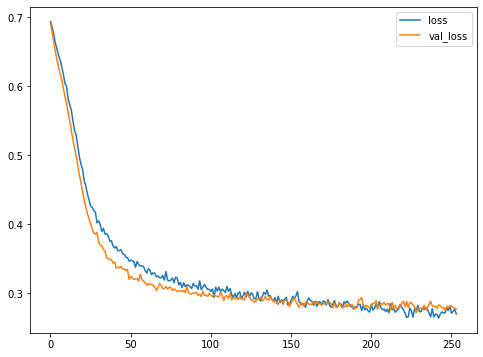

In [67]:
#Plot the training loss and validation loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])

plt.legend(['loss', 'val_loss'], loc='upper right')

fig=plt.gcf()
fig.set_size_inches(8,6)
plt.show()

Here we can see that our validation loss is decreasing over each epoch of training along with the training loss. Our early stop callback stopped the training around 180 epochs which is probably where we can start to see a rise in validation loss which means we would be overfitting the data.

### Final Model Selection:

After analyzing the proposed models, the best choice for predicting faction will be the regular decision tree with no max depth specified. Our logistic regression model was able to make decent predictions, but not as well as our decision tree model. The neural network model also had decent results which were very similar to the tree model; unfortunely the neural network is very computationally expensive and since we achieve the same results with the decision tree, it would be better to use a simpler model. For our problem of classifying 'Faction', we will choose to use the decision tree model. Let's do a little bit more exploring with this model:

In [68]:
#Function for generalizing performance across multiple train/test splits
#Will take some time to run depending on the number of splits

def Avg_Tree_Accuracy(X,Y,model,model_name,nsplits=100,test_size=0.3,kde=False):
    model_acc =[]
    for split in range(nsplits):
        XTRAIN, XTEST, YTRAIN, YTEST=train_test_split(X,Y,test_size=test_size,shuffle=True) #Split the data

        model = model
        model.fit(XTRAIN,YTRAIN)
        predictions = model.predict(XTEST)
        
        model_acc.append(accuracy_score(YTEST,predictions))
        
    model_mean = round(np.mean(model_acc),3)
    model_2sd=round(2*np.std(model_acc),3)
    print(f'{model_name} Mean Accuracy: {model_mean} +/- {model_2sd}')
    
    if kde == True:
        sns.kdeplot(model_acc,fill=True) #Optional plot

Decision Tree Mean Accuracy: 0.87 +/- 0.019


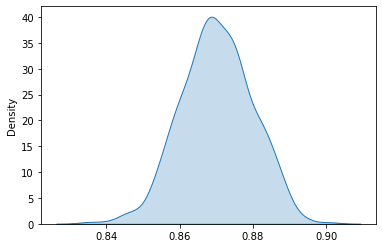

In [69]:
Avg_Tree_Accuracy(X,Y,DT(max_depth=None),'Decision Tree',nsplits=500,kde=True)

It's always a good idea to see how our model performs on different train/test splits since we could be getting results that are biased on the split or overfitting the training data based on the split. Looks like our model is performing great on average!

In [70]:
#Indivual classifications for each feature to compare affect on accuracy.

#For Xdata we pass in a feature dataframe

def feature_accuracy(Xdata,Y,model,test_size=0.3,top_features=5):
    feat_accs = {}
    
    for i in range(len(Xdata.columns)):
        X = np.array(Xdata[Xdata.columns[i]]).reshape(-1,1)
        XTRAIN, XTEST, YTRAIN, YTEST=train_test_split(X,Y,test_size=test_size,random_state=69,shuffle=True)
        
        model.fit(XTRAIN,YTRAIN) #Fit the model
        YPRED = model.predict(XTEST)
        
        accuracy = np.round(accuracy_score(YTEST,YPRED),3)
        feature_name=Xdata.columns[i]
        
        feat_accs[str(feature_name)] = accuracy
    #Returns a dictionary of features and their accuracies
    
    acc_df = pd.DataFrame(columns=['Feature','Accuracy']) #Create empty dataframe for top features/accuracies
    for j in range(top_features):
        max_value = max(feat_accs.values()) #Highest accuracy in dictionary
        max_key= max(feat_accs, key=feat_accs.get) #Feature name with highest accuracy
        
        acc_df.loc[len(acc_df)] = [max_key,max_value] #Insert new row into our dataframe
    
        feat_accs.pop(max_key) #Remove the feature we just added so it does not get selected again
        
    return acc_df #Dataframe of top features

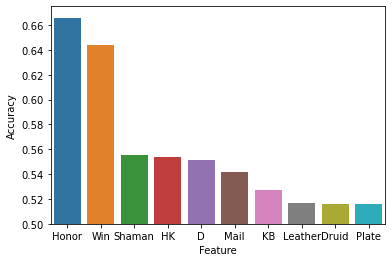

In [71]:
#Top 10 features based on individual accuracy contribution
accuracy_df = feature_accuracy(df.drop('Faction',axis=1),Y,DT(max_depth=None),top_features=10)
sns.barplot(x='Feature',y='Accuracy',data=accuracy_df)

plt.ylim(0.5,0.675)
plt.show()

These results are pretty interesting. From our function we were able to determine that the most contributing factors to predicting 'Faction' was the honor gained and if the match was a win or not (Horde are winning more battleground and getting more honor?). It is also interesting that whether the player was a shaman or not has a lot to do with their faction (one of the facitons has more shamans!). The last note is that three of the four armor types appeared in the top 10 features so this might suggest general class preference differences between the two factions.

---

---

## Regression: Predicting Honorable Kills

In [72]:
#Honorable Kills
X = np.array(df.drop('HK',axis=1))
Y = np.array(df['HK'])

XTRAIN, XTEST, YTRAIN, YTEST = train_test_split(X,Y,shuffle=True,random_state=69)

In [73]:
from sklearn.metrics import r2_score, mean_squared_error

### Linear Regression Model

In [74]:
from sklearn.linear_model import LinearRegression

In [75]:
XTRAIN, XTEST, YTRAIN, YTEST = train_test_split(X,Y,shuffle=True,random_state=69)
lm = LinearRegression()
lm.fit(XTRAIN,YTRAIN)
predictions = lm.predict(XTEST)

print('R2 Score: ',np.round(r2_score(YTEST,predictions),2)) #R^2

R2 Score:  0.59


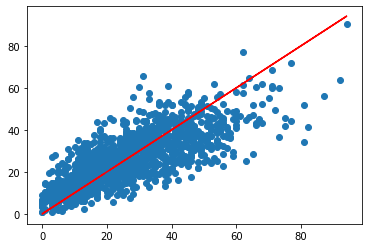

In [76]:
#Residual plot
plt.scatter(YTEST,predictions)
plt.plot(YTEST,YTEST,'r')

Our residual plot seems to have a decent fit from the linear model. We can see that the predictions are roughly following a linear pattern, but they do deviate from the center line a bit more than we'd like. This deviation is also expressed in the low R2 score.

<AxesSubplot:ylabel='Density'>

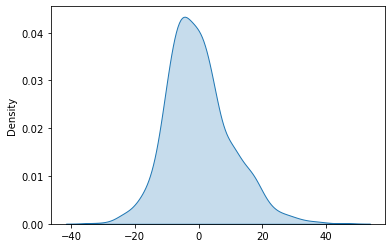

In [77]:
#Residual Distributions
residuals = YTEST - predictions
sns.kdeplot(residuals,fill=True)

The residuals for our linear model are normally distributed which is what we want. If the residuals had a different distribution, this would indicate that a linear model would probably not be the best fit for the regression problem we are trying to solve.

### Tree Models

In [78]:
from sklearn.tree import DecisionTreeRegressor as DTR

from sklearn.ensemble import RandomForestRegressor as RFR
from sklearn.ensemble import GradientBoostingRegressor as GBR
from sklearn.ensemble import BaggingRegressor as BAG
from sklearn.ensemble import ExtraTreesRegressor as XTRA

In this section we will compare many tree methods and see if we can achieve better results than we got from our linear model.

In [79]:
#Regular Decision Tree
XTRAIN, XTEST, YTRAIN, YTEST = train_test_split(X,Y,shuffle=True,random_state=69)

tree = DTR()
tree.fit(XTRAIN,YTRAIN)
predictions = tree.predict(XTEST)

print('R2 Score: ',np.round(r2_score(YTEST,predictions),2)) #R^2
print('Root Mean Squared Error: ',np.round(np.sqrt(mean_squared_error(YTEST,predictions)),2)) #RMSE

R2 Score:  0.41
Root Mean Squared Error:  12.19


In [80]:
#Random Forest
XTRAIN, XTEST, YTRAIN, YTEST = train_test_split(X,Y,shuffle=True,random_state=69)

tree = RFR(max_depth=None,n_estimators=100)
tree.fit(XTRAIN,YTRAIN)
predictions = tree.predict(XTEST)

print('R2 Score: ',np.round(r2_score(YTEST,predictions),2)) #R^2
print('Root Mean Squared Error: ',np.round(np.sqrt(mean_squared_error(YTEST,predictions)),2)) #RMSE

R2 Score:  0.72
Root Mean Squared Error:  8.43


In [81]:
#Boosting
XTRAIN, XTEST, YTRAIN, YTEST = train_test_split(X,Y,shuffle=True,random_state=69)

tree = GBR(n_estimators=400)
tree.fit(XTRAIN,YTRAIN)
predictions = tree.predict(XTEST)

print('R2 Score: ',np.round(r2_score(YTEST,predictions),2)) #R^2
print('Root Mean Squared Error: ',np.round(np.sqrt(mean_squared_error(YTEST,predictions)),2)) #RMSE

R2 Score:  0.73
Root Mean Squared Error:  8.24


In [82]:
#Bagging
XTRAIN, XTEST, YTRAIN, YTEST = train_test_split(X,Y,shuffle=True,random_state=69)

tree = BAG(n_estimators=30)
tree.fit(XTRAIN,YTRAIN)
predictions = tree.predict(XTEST)

print('R2 Score: ',np.round(r2_score(YTEST,predictions),2)) #R^2
print('Root Mean Squared Error: ',np.round(np.sqrt(mean_squared_error(YTEST,predictions)),2)) #RMSE

R2 Score:  0.71
Root Mean Squared Error:  8.64


In [83]:
#Extra Trees
XTRAIN, XTEST, YTRAIN, YTEST = train_test_split(X,Y,shuffle=True,random_state=69)

tree = XTRA(n_estimators=200)
tree.fit(XTRAIN,YTRAIN)
predictions = tree.predict(XTEST)

print('R2 Score: ',np.round(r2_score(YTEST,predictions),2)) #R^2
print('Root Mean Squared Error: ',np.round(np.sqrt(mean_squared_error(YTEST,predictions)),2)) #RMSE

R2 Score:  0.72
Root Mean Squared Error:  8.42


In [84]:
tree_info = {'Decision Tree': {'R2':0.41, 'RMSE':12.29},
            'Random Forest': {'R2':0.72, 'RMSE':8.42},
            'Gradient Boost': {'R2':0.73, 'RMSE':8.24},
            'Bagging': {'R2':0.72, 'RMSE':8.47},
            'Extra Trees': {'R2':0.73, 'RMSE':8.33}}

In [85]:
#Comparison of tree models
tree_df = pd.DataFrame(tree_info).transpose()
tree_df.head()

R2   RMSE
Decision Tree   0.41  12.29
Random Forest   0.72   8.42
Gradient Boost  0.73   8.24
Bagging         0.72   8.47
Extra Trees     0.73   8.33

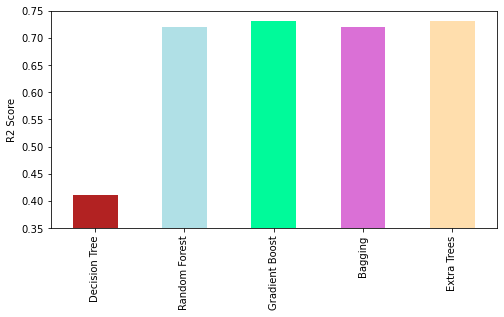

In [86]:
tree_df['R2'].plot(kind='bar',color=['firebrick','powderblue','mediumspringgreen','orchid','navajowhite'])

fig=plt.gcf()
fig.set_size_inches(8,4)

plt.ylim(0.35,0.75)
plt.ylabel('R2 Score')

plt.show()

Plotting the R2 scores against each other shows that the tree ensembles did great at improving the accuracy over a regular decision tree! All the different ensembles performed similarly with the gradient boost and extra trees methods on top.

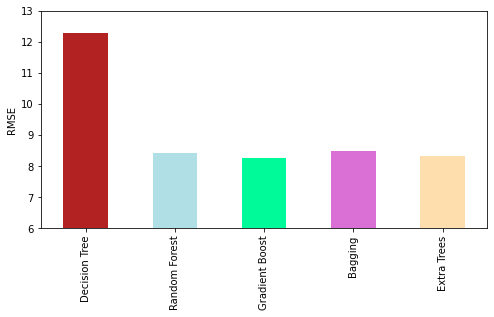

In [87]:
tree_df['RMSE'].plot(kind='bar',color=['firebrick','powderblue','mediumspringgreen','orchid','navajowhite'])

fig=plt.gcf()
fig.set_size_inches(8,4)

plt.ylim(6,13)
plt.ylabel('RMSE')

plt.show()

Taking a look at the Root Mean Squared Errors between all the models, we again can see how the ensembles improves the performance of the model and reduced the RMSE compared to a regular decision tree. Again the gradient boost and extra trees methods seemed to have the best results.

### Neural Network

In [88]:
XTRAIN, XTEST, YTRAIN, YTEST = train_test_split(X,Y,shuffle=True,random_state=69)

scaler = MinMaxScaler()
scaler.fit(XTRAIN)
XTRAIN = scaler.transform(XTRAIN)
XTEST = scaler.transform(XTEST)

#Initializing an early stop to optmimize the number of training epochs
early_stop = EarlyStopping(monitor='val_loss',mode='min',verbose=0,patience=25)

In [89]:
#Building the model
model = Sequential()

model.add(Dense(45,activation='elu'))
model.add(Dense(30,activation='relu'))

model.add(Dense(1))

model.compile(loss='mse',optimizer='adam')

history = model.fit(x=XTRAIN,y=YTRAIN,epochs=500,validation_data=(XTEST,YTEST),
                    batch_size=32,callbacks=[early_stop],verbose=0)

predictions = model.predict(XTEST)

43/43 [==============================] - 0s 475us/step


In [90]:
print('R2 Score: ',np.round(r2_score(YTEST,predictions),2)) #R^2
print('Root Mean Squared Error: ',np.round(np.sqrt(mean_squared_error(YTEST,predictions)),2)) #RMSE

R2 Score:  0.66
Root Mean Squared Error:  9.24


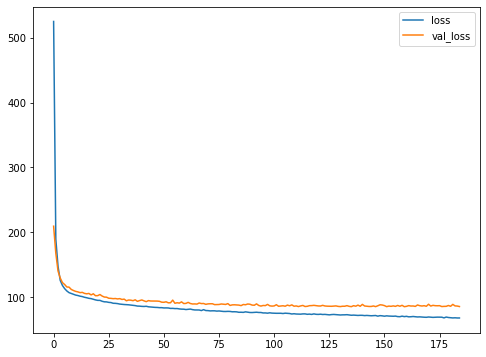

In [91]:
#Plot the training loss and validation loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])

plt.legend(['loss', 'val_loss'], loc='upper right')

fig=plt.gcf()
fig.set_size_inches(8,6)
plt.show()

Our neural network model didn't perform as well as we'd like. The R2 score is fairly low and with an RMSE of ~9, we are off by about 9 honorable kills when making our predictions (ideally we would like to be around 1 or 2 for RMSE).

### Final Model Selection:

After analyzing the proposed models for our regression task, we found that the best performing models were the tree regressors (specifically the gradient boosting model and extra trees model). Our multiple linear regression fit the data okay, but not well enough to use on future data. The neural network model performed a bit better, but because it is more computationally expensive to use this type of model and we didn't even achieve better results with it, we will opt to use the tree ensembles. Let's do some final analysis on a gradient boosting tree model (since it's so similar to the extra trees model we will only analyze one).

In [92]:
#Function for generalizing performance across multiple train/test splits
#Will take some time to run depending on the number of splits

def Avg_Tree_R2(X,Y,model_name,nsplits=100,test_size=0.3,kde=False):
    model_R2 =[]
    for split in range(nsplits):
        XTRAIN, XTEST, YTRAIN, YTEST=train_test_split(X,Y,test_size=test_size,shuffle=True) #Split the data

        model = GBR(n_estimators=400)
        model.fit(XTRAIN,YTRAIN)
        predictions = model.predict(XTEST)
        
        model_R2.append(r2_score(YTEST,predictions))
        
    model_mean = round(np.mean(model_R2),3)
    model_2sd=round(2*np.std(model_R2),3)
    print(f'{model_name} Mean R2 Score: {model_mean} +/- {model_2sd}')
    
    if kde == True:
        sns.kdeplot(model_R2,fill=True) #Optional plot

Gradient Boosting Regressor Mean R2 Score: 0.75 +/- 0.019


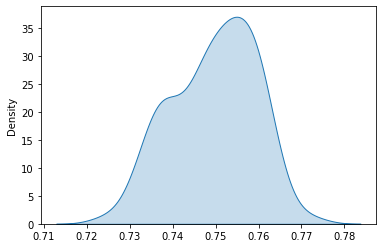

In [93]:
Avg_Tree_R2(X,Y,'Gradient Boosting Regressor',nsplits=100,kde=True)

Looks like our model is doing okay, hovering around a 0.75 R2 score. This means that on average, our model is able to explain about 75% of the variability in 'Honorable Kills'. The low R2 score indicates that we are missing some explanatory variables that contain more information about and correlation with the amount of honorable kills in a battleground. Different battleground statistics should be considered to see if they can add any more variance explanation to our regressions models.

---

# Conclusion

It was interesting to break down and analyze our battleground dataset to see what trends we could find between a player's combat statistics and other character information. Overall, we saw a nice sense of balance among most of the classes, factions, and roles which indiciates that the game design is working well in PvP. We were able to find some slight differences between these variables that were of interest.

### Faction Classification:

The good news is that the distribution of wins was pretty much even between the two factions (indicating good faction balance). We were able to find a bunch of features that separated the two factions well which allowed us to build a predictive model which could guess the faction almost 90% of the time. This shows that the although the two factions win as often as they lose, they also have their own distinct playstlyes. Based on a player's performance in a battleground, we could have a pretty good idea which faction they were fighting for!

### Honorable Kills Regression:

The number of honorable kills a player has is a good indication of how often they participated in combat. In general, we found that Horde players tend to favor combat a bit more than the Alliance players. After building some models, we determined that more data would be needed to accuractely predict the number of honorable kills a player will obtain in a battleground. There are variables not included within this dataset that are contributing to a player's honorable kills that we have yet to discover. Other possible variables to monitor might be a player's overall PvP stats (veterans might get more honorable kills) or length of a match (longer battlegrounds allow for more honorable kills!).

---

#### No matter which side you choose, battlegrounds will still remain a staple to the PvP community and the perfect opportunity to prove yourself in battle!